# Кластеризация ЕГЭ (8.5 если сделаны все задачи)

Рядом лежат экселевские таблицы с координатами точек. В 3 и 4 задаче используется манхетеское расстояние. В остальных Евклидово.

* Постройте Распределение точек
* Кластеризуйте руками
* Постройте Распределение точек, отметьте принадлежность кластеров цветами
* Найдите среди в каждом кластере точку расстояние от которой до всех остальных минимально
* Выведите усреднение центров всех кластеров * 1000

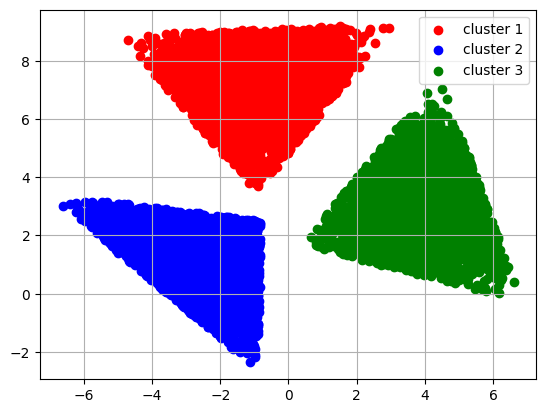

61
3723


In [8]:
import matplotlib.pyplot as plt
import math
def eug_dist(x1, y1, x2, y2):
    return math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)



def center_f(cluster):
    min_dist = float('inf')
    my_center = []
    for center in cluster:
        dist = 0
        for point in cluster:
            dist += eug_dist(point[0], point[1], center[0], center[1])
        if dist < min_dist:
            min_dist = dist
            my_center = center
    return my_center
f = open("5.txt","r")
points = []
cluster1 = []
cluster2 = []
cluster3 = []
for line in f:
    line = line.replace(",",".")
    points.append(list(map(float, line.split())))

    x, y = points[-1]
    if 2 + 1.3 * x < y and 2.6 - 0.9 * x < y:
        cluster1.append(points[-1])
    elif x < 0:
        cluster2.append(points[-1])
    else:
        cluster3.append(points[-1])

plt.scatter([x for x, y in cluster1], [y for x, y in cluster1], color='red', label='cluster 1')
plt.scatter([x for x, y in cluster2], [y for x, y in cluster2], color='blue', label='cluster 2')
plt.scatter([x for x, y in cluster3], [y for x, y in cluster3], color='green', label='cluster 3')



plt.legend()
plt.grid(True)
plt.show()


center1 = center_f(cluster1)
center2 = center_f(cluster2)
center3 = center_f(cluster3)


print(int((center1[0] + center2[0] + center3[0]) / 3 * 1000))
print(int((center1[1] + center2[1] + center3[1] ) / 3 * 1000))



# Кластеризация (0.75 за каждый алгоритм на всех данных)

На предложенных распределениях данных проверьте предложенные алгоритмы. Постройте графики кластеризации для каждой пары алгоритм-данные, разные кластеры покрасьте разным цветом. Воспользуйтесь sklearn реализациями. Параметры кластеризации для разных алгоритмов подберите такие, чтобы алгоритмы можно было сравнивать (по возможности одинаковое количество кластеров и т.д.)

In [5]:
import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

In [6]:
two_means =  cluster.MiniBatchKMeans(n_clusters=2)
dbscan = cluster.DBSCAN(eps=0.5, min_samples=1)

clustering_algorithms = (
        ("MiniBatch\nKMeans", two_means),
        ("DBSCAN", dbscan),
    )

SyntaxError: invalid syntax (3112512487.py, line 1)

In [3]:
np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

plot_num = 1

default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 10,
    "n_clusters": 3,
    "min_samples": 20,
    "xi": 0.05,
    "min_cluster_size": 0.1,
}

datasets = [
    (
        noisy_circles,
        {
            "damping": 0.77,
            "preference": -240,
            "quantile": 0.2,
            "n_clusters": 2,
            "min_samples": 20,
            "xi": 0.25,
        },
    ),
    (noisy_moons, {"damping": 0.75, "preference": -220, "n_clusters": 2}),
    (
        varied,
        {
            "eps": 0.18,
            "n_neighbors": 2,
            "min_samples": 5,
            "xi": 0.035,
            "min_cluster_size": 0.2,
        },
    ),
    (
        aniso,
        {
            "eps": 0.15,
            "n_neighbors": 2,
            "min_samples": 20,
            "xi": 0.1,
            "min_cluster_size": 0.2,
        },
    ),
    (blobs, {}),
    (no_structure, {}),
]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

NameError: name 'np' is not defined